In [1]:
from numpy import *             # Grab all of the NumPy functions
import matplotlib.pyplot as plt  # Grab MATLAB plotting functions
import control.matlab as mtl    # MATLAB-like functions
import control as ctrl
%matplotlib inline
from sympy import *
import pandas as pd
import scipy.signal as signal

## References
Python-Control Reference:
    - https://python-control.readthedocs.io/en/0.8.3/intro.html
Scipy.Signal Reference
    - https://docs.scipy.org/doc/scipy/reference/signal.html
   

In [2]:
#test C2D...serve as reference and playground
k  = 3.0
wn = 2.0 #rad/sec
zeta = 0.1
dT = 0.1
numc = [k*wn**2]
denc = [1,2*wn*zeta,wn**2]
sysc = mtl.tf( numc, denc)
sysd = signal.cont2discrete([numc,denc],dT)
print(sysc.damp()) #will return Wn_array, zeta_array, poles_array of continuous system
sysd_mtl = mtl.tf(sysd[0][0],sysd[1],sysd[2])
print(sysd_mtl.damp()) #will return Wn_array, zeta_array, poles_array of discrete system
#sysd[0][0]

(array([2., 2.]), array([0.1, 0.1]), array([-0.2+1.98997487j, -0.2-1.98997487j]))
(array([2., 2.]), array([0.1, 0.1]), array([0.9608547+0.19377224j, 0.9608547-0.19377224j]))


Define systems

In [3]:
#First System
s, K1, T1, Ki1, Kp1, C1, G1, CL1, Ttune1, Tguess1, Kguess1, M1, alpha1 = symbols('s K1 T1 Ki1 Kp1 C1 G1 CL1 Ttune1 Tguess1 Kguess1 M1 alpha1 ')
#second Ssytem
K2, T2, Ki2, Kp2, C2, G2, CL2, Ttune2, Tguess2, Kguess2, M2, alpha2 = symbols('K2 T2 Ki2 Kp2 C2 G2 CL2 Ttune2 Tguess2 Kguess2 M2 alpha2 ')

First Order 

In [4]:
#innerLoop
expr_G1 =  K1/(T1*s+1)
expr_C1 = Kp1+Ki1/s

In [5]:
expr_CL1 = expr_C1*expr_G1 / (1 + expr_C1*expr_G1)
expr_CL1

K1*(Ki1/s + Kp1)/((T1*s + 1)*(K1*(Ki1/s + Kp1)/(T1*s + 1) + 1))

In [6]:
collect(expr_CL1.simplify().expand(),s)

K1*Ki1/(K1*Ki1 + T1*s**2 + s*(K1*Kp1 + 1)) + K1*Kp1*s/(K1*Ki1 + T1*s**2 + s*(K1*Kp1 + 1))

Test The Control

In [7]:
#Tuning Params Substitution
# Let Ttune = Trise/Ln(9) 

expr_CL1_tuned = expr_CL1.subs(Kp1,Tguess1/(Kguess1*Ttune1))
expr_CL1_tuned = expr_CL1_tuned.subs(Ki1,1/(Kguess1*Ttune1))
collect(expr_CL1_tuned.simplify().expand(),s)


K1*Tguess1*s/(K1 + Kguess1*T1*Ttune1*s**2 + s*(K1*Tguess1 + Kguess1*Ttune1)) + K1/(K1 + Kguess1*T1*Ttune1*s**2 + s*(K1*Tguess1 + Kguess1*Ttune1))

In [8]:
#Test Replacement with Margin of Errror in ID, where Kreal = M * Kguess; Treal = M*Tgues
expr_CL1_tuned_m = expr_CL1_tuned.subs(K1,M1*Kguess1)
expr_CL1_tuned_m = expr_CL1_tuned_m.subs(T1,M1*Tguess1)
expr_CL1_tuned_m = collect(expr_CL1_tuned_m.simplify().expand(),s)
expr_CL1_tuned_m

M1*Tguess1*s/(M1*Tguess1*Ttune1*s**2 + M1 + s*(M1*Tguess1 + Ttune1)) + M1/(M1*Tguess1*Ttune1*s**2 + M1 + s*(M1*Tguess1 + Ttune1))

In [9]:
#Now check the Response using Control -- Specs
m1 = 1.1
t1 = 1.0
k1 = 1.0
a1  = 10.0 #alpha 
tguess1 = t1/m1
kguess1 = k1/m1
ttune1 = tguess1/a1
kp1 = tguess1 / kguess1 / ttune1
ki1 = kp1 / tguess1
num = [m1*tguess1, m1]
den = [m1*tguess1*ttune1, m1*tguess1+ttune1, m1]

In [10]:
#Continuous Time Model
tf1 = mtl.tf(num,den)
damp = tf1.damp()
print('system: ',tf1)
print('wn:',damp[0],' zeta:',damp[1],' poles:',damp[2])

system:  
          s + 1.1
---------------------------
0.09091 s^2 + 1.091 s + 1.1

wn: [10.88876262  1.11123738]  zeta: [1. 1.]  poles: [-10.88876262  -1.11123738]


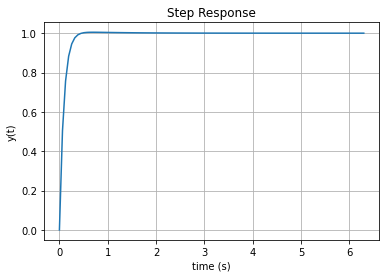

In [11]:
t, y = mtl.step(tf1)
plt.plot(y, t)
plt.title("Step Response")
plt.grid()
plt.xlabel("time (s)")
plt.ylabel("y(t)")
plt.show()

In [12]:
#check the discretized model
dT = 0.001
sysd = signal.cont2discrete([num,den],dT)
sysd_mtl = mtl.tf(sysd[0][0],sysd[1],sysd[2])
damp = sysd_mtl.damp()
print('system: ',sysd_mtl)
print('wn:',damp[0],' zeta:',damp[1],' poles:',damp[2])

system:  
  0.01094 z - 0.01093
----------------------
z^2 - 1.988 z + 0.9881

dt = 0.001

wn: [ 1.11123738 10.88876262]  zeta: [1. 1.]  poles: [0.99888938 0.98917031]


In [13]:
#check Stability Margins for a range of alphas and M1s
m1r = [0.8, 0.9, 1.0, 1.1, 1.2]
a1r = [2.0, 5.0, 10.0, 20.0, 50.0]
sys_c_stab = pd.DataFrame(data={'Alpha:':[], 'margin':[], 'PM':[], 'GM':[], 'SM':[], 'WG':[], 'WP':[], 'WS':[], 'Wn':[], 'Zeta':[], 'Poles':[]}) 
sys_d_stab = pd.DataFrame(data={'Alpha:':[], 'margin':[], 'PM':[], 'GM':[], 'SM':[], 'WG':[], 'WP':[], 'WS':[], 'Wn':[], 'Zeta':[], 'Poles':[]}) 
#sys1_stab = pd.DataFrame([[a,m,pmt,gmt,smt,wgt,wpt,wst]],columns = ['Alpha','margin','PM','GM','SM','WG','WP','WS'])
dT = 0.001

def update_tf(m,a,t1,k1,dT):
    tguess1 = t1/m
    kguess1 = k1/m
    ttune1 = tguess1/a
    num = [m*tguess1, m]
    den = [m*tguess1*ttune1, m*tguess1+ttune1, m]
    #kp1 = tguess1 / kguess1 / ttune1
    #ki1 = kp1 / tguess1
    tfc = mtl.tf(num,den)
    sysd = signal.cont2discrete([num,den],dT)
    tfd = mtl.tf(sysd[0][0],sysd[1],sysd[2])
    return tfc,tfd
    

for a in a1r:
    for m in m1r:
        tfc,tfd = update_tf(m,a,1.0,1.0,dT)
        gmt,pmt,smt,wgt,wpt,wst = ctrl.stability_margins(tfc)
        damp = tfc.damp()
        dfc = pd.DataFrame([[a,m,pmt,gmt,smt,wgt,wpt,wst,damp[0],damp[1],damp[2]]],columns = ['Alpha','margin','PM','GM','SM','WG','WP','WS','Wn','Zeta','Poles'])
        sys_c_stab = sys_c_stab.append(dfc,ignore_index=True)
        gmt,pmt,smt,wgt,wpt,wst = ctrl.stability_margins(tfd)
        damp = tfd.damp()
        dfc = pd.DataFrame([[a,m,pmt,gmt,smt,wgt,wpt,wst,damp[0],damp[1],damp[2]]],columns = ['Alpha','margin','PM','GM','SM','WG','WP','WS','Wn','Zeta','Poles']) 
        sys_d_stab = sys_d_stab.append(dfc,ignore_index=True)
        
        

In [14]:
print('Cont: ',sys_c_stab.info())
print('Disc: ',sys_d_stab.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Alpha:  0 non-null      float64
 1   margin  25 non-null     float64
 2   PM      25 non-null     float64
 3   GM      25 non-null     float64
 4   SM      25 non-null     float64
 5   WG      0 non-null      float64
 6   WP      8 non-null      float64
 7   WS      0 non-null      float64
 8   Wn      25 non-null     object 
 9   Zeta    25 non-null     object 
 10  Poles   25 non-null     object 
 11  Alpha   25 non-null     float64
dtypes: float64(9), object(3)
memory usage: 2.5+ KB
Cont:  None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Alpha:  0 non-null      float64
 1   margin  25 non-null     float64
 2   PM      25 non-null     float64
 3   GM      25 non-null   

In [15]:
print('Cont min PM: ',sys_c_stab['PM'].min(), ' GM:',sys_c_stab['GM'].min(), ' Zeta:',sys_c_stab['Zeta'][0].min())
print('Disc min PM: ',sys_d_stab['PM'].min(), ' GM:',sys_d_stab['GM'].min(), ' Zeta:',sys_d_stab['Zeta'][0].min())

Cont min PM:  169.59892228006845  GM: inf  Zeta: 1.0
Disc min PM:  inf  GM: 0.9999999999080991  Zeta: 1.0


In [16]:
#create Outer Loop
expr_G2 = expr_CL1 * K2/(T2*s+1)
expr_C2 = Kp2+Ki2/s
expr_CL2 = expr_C2 * expr_G2 / (1 + expr_C2*expr_G2)
collect(expr_CL2.simplify().expand(),s)

K1*K2*Ki1*Ki2/(K1*K2*Ki1*Ki2 + T1*T2*s**4 + s**3*(K1*Kp1*T2 + T1 + T2) + s**2*(K1*K2*Kp1*Kp2 + K1*Ki1*T2 + K1*Kp1 + 1) + s*(K1*K2*Ki1*Kp2 + K1*K2*Ki2*Kp1 + K1*Ki1)) + K1*K2*Kp1*Kp2*s**2/(K1*K2*Ki1*Ki2 + T1*T2*s**4 + s**3*(K1*Kp1*T2 + T1 + T2) + s**2*(K1*K2*Kp1*Kp2 + K1*Ki1*T2 + K1*Kp1 + 1) + s*(K1*K2*Ki1*Kp2 + K1*K2*Ki2*Kp1 + K1*Ki1)) + s*(K1*K2*Ki1*Kp2/(K1*K2*Ki1*Ki2 + T1*T2*s**4 + s**3*(K1*Kp1*T2 + T1 + T2) + s**2*(K1*K2*Kp1*Kp2 + K1*Ki1*T2 + K1*Kp1 + 1) + s*(K1*K2*Ki1*Kp2 + K1*K2*Ki2*Kp1 + K1*Ki1)) + K1*K2*Ki2*Kp1/(K1*K2*Ki1*Ki2 + T1*T2*s**4 + s**3*(K1*Kp1*T2 + T1 + T2) + s**2*(K1*K2*Kp1*Kp2 + K1*Ki1*T2 + K1*Kp1 + 1) + s*(K1*K2*Ki1*Kp2 + K1*K2*Ki2*Kp1 + K1*Ki1)))

In [17]:
#check step response
#Now check the Response using Control -- Specs

t1 = 0.2
t2 = 0.6
k1 = 1.2
k2 = 0.8
m1 = 1.2
m2 = 1.2
a1  = 10.0 #alpha 
a2  = 5.0

tguess1 = t1/m1
kguess1 = k1/m1
ttune1 = tguess1/a1
tguess2 = t2/m2
kguess2 = k2/m2
ttune2 = tguess2/a2
kp1 = tguess1 / kguess1 / ttune1
ki1 = kp1 / tguess1
kp2 = tguess2 / kguess2 / ttune2
ki2 = kp2 / tguess2

ds4 = t1*t2
ds3 = k1*kp1*t2 + t1 + t2
ds2 = k1*k2*kp1*kp2 + k1*ki1*t2 + k1*kp1 + 1
ds1 = k1*k2*ki1*kp2 + k1*k2*ki2*kp1 + k1*ki1
ds0 = k1*k2*ki1*ki2

ns2 = k1*k2*kp1*kp2
ns1 = k1*k2*ki1*kp2 + k1*k2*ki2*kp1
ns0 = k1*k2*ki1*ki2


den_cas = [ds4,ds3,ds2,ds1,ds0]
num_cas = [ns2,ns1,ns0]

tf_cascade = mtl.tf(num_cas,den_cas)
tf_cascade


           72 s^2 + 576 s + 864
------------------------------------------
0.12 s^4 + 8 s^3 + 128.2 s^2 + 648 s + 864

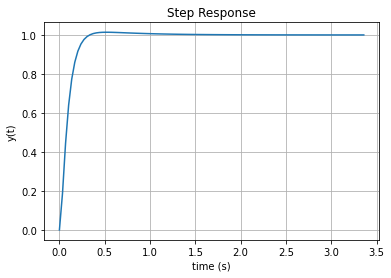

In [18]:
t, y = mtl.step(tf_cascade)
plt.plot(y, t)
plt.title("Step Response")
plt.grid()
plt.xlabel("time (s)")
plt.ylabel("y(t)")
plt.show()

In [27]:
#Check Outer/Inner Loops tuning results using Control Module

m1r = [0.5,0.8, 0.9, 1.0, 1.1, 1.2,2.0]
a1r = [2.0, 5.0, 10.0, 20.0, 50.0]
m2r = [0.5,0.8, 0.9, 1.0, 1.1, 1.2,2.0]
a2r = [0.5, 2.0, 5.0, 7.5, 10.0]
t1 = 0.3
t2 = 1.0
k1 = 2.0
k2 = 1.0

dT2 = 0.010
sys_c_stab_cas = pd.DataFrame(data={'a1:':[], 'm1':[], 'a2:':[], 'm2':[], 'PM':[], 'GM':[], 'SM':[], 'WG':[], 'WP':[], 'WS':[], 'Wn':[], 'Zeta':[], 'Poles':[]}) 
sys_d_stab_cas = pd.DataFrame(data={'a1:':[], 'm1':[], 'a2:':[], 'm2':[], 'PM':[], 'GM':[], 'SM':[], 'WG':[], 'WP':[], 'WS':[], 'Wn':[], 'Zeta':[], 'Poles':[]}) 

def update_cascaded_tf_cd(m1,a1,m2,a2,t1,t2,k1,k2,dT):
    tguess1 = t1/m1
    kguess1 = k1/m1
    ttune1 = tguess1/a1

    tguess2 = t2/m2
    kguess2 = k2/m2
    ttune2 = tguess2/a2

    kp1 = tguess1 / kguess1 / ttune1
    ki1 = kp1 / tguess1

    kp2 = tguess2 / kguess2 / ttune2
    ki2 = kp2 / tguess2

    ds4 = t1*t2
    ds3 = k1*kp1*t2 + t1 + t2
    ds2 = k1*k2*kp1*kp2 + k1*ki1*t2 + k1*kp1 + 1
    ds1 = k1*k2*ki1*kp2 + k1*k2*ki2*kp1 + k1*ki1
    ds0 = k1*k2*ki1*ki2

    ns2 = k1*k2*kp1*kp2
    ns1 = k1*k2*ki1*kp2 + k1*k2*ki2*kp1
    ns0 = k1*k2*ki1*ki2


    den_cas = [ds4,ds3,ds2,ds1,ds0]
    num_cas = [ns2,ns1,ns0]

    tfc = mtl.tf(num_cas,den_cas)
    sysd = signal.cont2discrete([num_cas,den],dT)
    tfd = mtl.tf(sysd[0][0],sysd[1],sysd[2])
    return tfc,tfd

for a1 in a1r:
    for m1 in m1r:
        for a2 in a2r:
            for m2 in m1r:
                tfc,tfd = update_cascaded_tf_cd(m1,a1,m2,a2,t1,t2,k1,k2,dT)
                gmt,pmt,smt,wgt,wpt,wst = ctrl.stability_margins(tfc)
                damp = tfc.damp()
                dfc = pd.DataFrame([[a1,m1,a2,m2,pmt,gmt,smt,wgt,wpt,wst,damp[0],damp[1],damp[2]]],columns = ['a1','m1','a2','m2','PM','GM','SM','WG','WP','WS','Wn','Zeta','Poles'])
                sys_c_stab_cas = sys_c_stab_cas.append(dfc,ignore_index=True)
                gmt,pmt,smt,wgt,wpt,wst = ctrl.stability_margins(tfd)
                damp = tfd.damp()
                dfc = pd.DataFrame([[a1,m1,a2,m2,pmt,gmt,smt,wgt,wpt,wst,damp[0],damp[1],damp[2]]],columns = ['a1','m1','a2','m2','PM','GM','SM','WG','WP','WS','Wn','Zeta','Poles']) 
                sys_d_stab_cas = sys_d_stab_cas.append(dfc,ignore_index=True)


In [28]:
print('Cont: ',sys_c_stab_cas.info())
print('Disc: ',sys_d_stab_cas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a1:     0 non-null      float64
 1   m1      1225 non-null   float64
 2   a2:     0 non-null      float64
 3   m2      1225 non-null   float64
 4   PM      1225 non-null   float64
 5   GM      1225 non-null   float64
 6   SM      1225 non-null   float64
 7   WG      0 non-null      float64
 8   WP      496 non-null    float64
 9   WS      1225 non-null   float64
 10  Wn      1225 non-null   object 
 11  Zeta    1225 non-null   object 
 12  Poles   1225 non-null   object 
 13  a1      1225 non-null   float64
 14  a2      1225 non-null   float64
dtypes: float64(12), object(3)
memory usage: 143.7+ KB
Cont:  None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a1:     0 n

In [29]:
print('Cont min PM: ',sys_c_stab_cas['PM'].min(), ' GM:',sys_c_stab_cas['GM'].min(), ' Zeta:',sys_c_stab_cas['Zeta'][0].min())
print('Disc min PM: ',sys_d_stab_cas['PM'].min(), ' GM:',sys_d_stab_cas['GM'].min(), ' Zeta:',sys_d_stab_cas['Zeta'][0].min())

Cont min PM:  38.37753901858446  GM: inf  Zeta: 0.9671462266086273
Disc min PM:  inf  GM: inf  Zeta: 1.0


In [24]:
sys_c_stab_cas['PM'].idxmin()

34

In [30]:
sys_c_stab_cas.iloc[sys_c_stab_cas['PM'].idxmin()]

a1:                                                    NaN
m1                                                     0.5
a2:                                                    NaN
m2                                                       2
PM                                                 38.3775
GM                                                     inf
SM                                                0.521158
WG                                                     NaN
WP                                                 10.6492
WS                                                 12.0267
Wn       [7.7799580059284885, 7.7799580059284885, 2.318...
Zeta     [0.24194748741985816, 0.24194748741985816, 1.0...
Poles    [(-1.8823412917664077+7.548810358945438j), (-1...
a1                                                       2
a2                                                      10
Name: 34, dtype: object

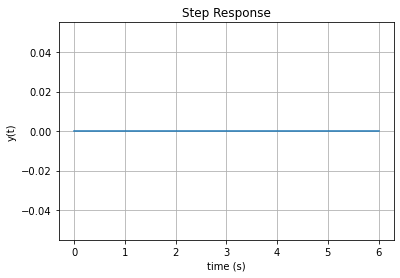

In [235]:
#discrete domain
def discretize_ft()